In [1]:
import sys
sys.path.append('../src')

In [2]:
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
import tensorflow as tf

In [4]:
from gait.config import pd
from gait.utils import get_data_by_overlap_percent,get_overlap_data_all_sessions,  split_test_train_by_subjects, remove_invalid_data, get_overlap_data_all_sessions
from gait.training import train_model
from gait.evalution import save_history, save_test_history, save_accuracy_loss_figure, save_confusion_matrix_figure, compute_validations_predictions

In [27]:
OVERLAP_PERCENT = 50
exclude_subjects = ['ddAeJA42PXvwthbW','nan','MMuX9YIh4NTbLZLM', 'PE8D53oX060qLbdX','xYdtS1F8tDyjEIgN'];

X, y, subjects = get_data_by_overlap_percent(OVERLAP_PERCENT)
indexes = np.where(subjects == exclude_subjects)
X = np.delete(X, indexes[0], axis=0)
y = np.delete(y, indexes[0], axis=0)
subjects = np.delete(subjects, indexes[0], axis=0)

nan_indices [    3 10469]


In [40]:
ax = X[:,:,0]
print(ax.shape)
print(ax.mean(axis=1).shape)

(2903, 128)
(2903,)


In [28]:
print(X.shape)
print(X[0][0])
def compute_resultant_acceleration(X):
    return np.sqrt(X[:,:,0] **2 + X[:,:,1] ** 2 + X[:,:,2] ** 2)

def compute_resultant_gyro(X):
    return np.sqrt(X[:,:,3] **2 + X[:,:,4] ** 2 + X[:,:,5] ** 2)

resultant_acc =compute_resultant_acceleration(X)
resultant_gyro=compute_resultant_gyro(X)

resultant_acc=resultant_acc.reshape(resultant_acc.shape[0], resultant_acc.shape[1], 1)
resultant_gyro = resultant_gyro.reshape(resultant_gyro.shape[0], resultant_gyro.shape[1], 1)
X = np.concatenate((X, resultant_acc), axis=2)
X = np.concatenate((X, resultant_gyro), axis=2)

print(X.shape)

(2903, 128, 9)
[-0.25     -0.060181  0.435425 -1.037598  0.427246  0.579834  0.518746
  0.037721 -0.135075]
(2903, 128, 11)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
UNIQUE>>>>>>> ['NKdnm6cN3KKAx7R4', 'EUbKPOSQgjccjtvi', 'psiuhPJmLIa2wC4u']
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 11, 8)        976       
                                                                 
 average_pooling2d (AverageP  (None, 42, 3, 8)         0         
 ooling2D)                                                       
                                                                 
 batch_normalization (BatchN  (None, 42, 3, 8)         32        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 42, 3, 32)         1056      
                                                                 
 average_po

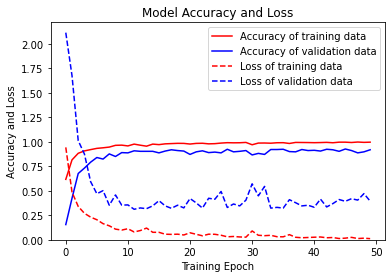

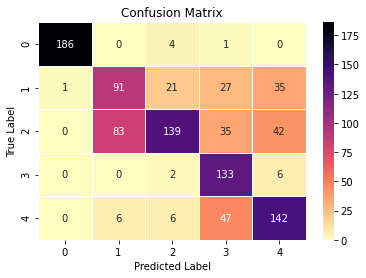

In [29]:
gpus = tf.config.list_logical_devices('GPU')
strategy = tf.distribute.MirroredStrategy(gpus)
with strategy.scope():
    X_train, X_test, y_train, y_test, y_train_non_encoded, y_test_non_encoded = split_test_train_by_subjects(
    X, y, subjects, train_percent=0.8)
    model, history, evaluation_history = train_model(X_train, y_train, X_test, y_test, overlap_percent=OVERLAP_PERCENT, batch_size=32, epochs=50, variant="cnn")
    save_history(history, OVERLAP_PERCENT)
    save_test_history(evaluation_history, OVERLAP_PERCENT)
    save_accuracy_loss_figure(history, OVERLAP_PERCENT)
    validations, predictions = compute_validations_predictions(
        model, X_test, y_test)
    save_confusion_matrix_figure(validations, predictions, OVERLAP_PERCENT, sns)